In [ ]:
# fata from and notebook created for Kaggle competition 'Predict Future Sales'
# https://www.kaggle.com/c/competitive-data-science-predict-future-sales

# using notebook 'Time series Basics : Exploring traditional TS' by jagangupta for reference 
# https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

In [8]:
!pip3 install tensorflow==2.0.0rc numpy sklearn tqdm matplotlib --no-cache-dir

In [38]:
# import basic packages 

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import random as rd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# import time series packages 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [43]:
# import data

item = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
sample_sub = pd.read_csv('competitive-data-science-predict-future-sales/sample_submission.csv')
shop = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')

In [61]:
# display a random sample of items

item.sample(5, random_state=0)

,item_name,item_id,item_category_id
19833,ТРИ МУШКЕТЕРА (2013) (BD),19833,37
21453,ХРОНИКИ НАРНИИ ПОКОРИТЕЛЬ ЗАРИ (регион),21453,40
15248,Мягкая игрушка Angry Birds Space со звуком 12...,15248,63
10523,ГРИБОК-ТЕРЕМОК (+мультфильм в подарок),10523,40
13714,Кружка Walking Dead The Banner,13714,69


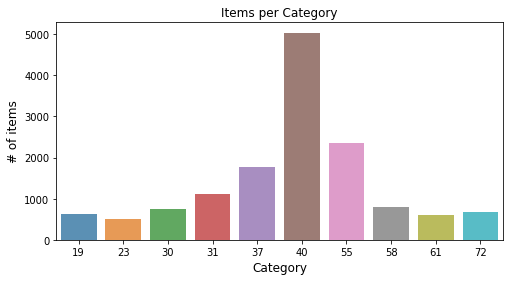

In [62]:
#  get the number of items in each category and plot the results 

num_cat=item.groupby(['item_category_id']).count()  # get the number of catergories for each item
num_cat=num_cat.sort_values(by='item_id',ascending=False)  # arrange by item id 
num_cat=num_cat.iloc[0:10].reset_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(num_cat.item_category_id, num_cat.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [58]:
# display a random sample of item categories 

num_cats = len(np.unique(item_cat['item_category_id']))  # number of categories 

item_cat.sample(5, random_state=0)


,item_category_name,item_category_id
30,Игры PC - Стандартные издания,30
40,Кино - DVD,40
43,Книги - Аудиокниги,43
50,Книги - Открытки,50
22,Игры - PSVita,22


In [48]:
# display a random sample of sales train 

sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y')) # format date column correctly 
print(sales.info())
sales.sample(5, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2633591,2015-05-08,28,31,13688,999.0,1.0
1077216,2013-11-22,10,25,7856,799.0,2.0
2673709,2015-06-19,29,42,20091,169.0,1.0
880503,2013-09-14,8,15,18344,199.0,1.0
893057,2013-09-21,8,31,7882,1390.0,1.0


In [29]:
# display a random sample of sample submission 

sample_sub.sample(5, random_state=0)

,ID,item_cnt_month
210069,210069,0.5
4825,4825,0.5
145585,145585,0.5
58168,58168,0.5
54059,54059,0.5


In [31]:
# display a random sample of shops 

shop.sample(5, random_state=0)

,shop_name,shop_id
26,"Москва ТЦ ""Ареал"" (Беляево)",26
35,"Н.Новгород ТРЦ ""Фантастика""",35
59,"Ярославль ТЦ ""Альтаир""",59
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28
11,Жуковский ул. Чкалова 39м²,11


In [32]:
# display a random sample of test

test.sample(5, random_state=0)

,ID,shop_id,item_id
210069,210069,45,5060
4825,4825,5,10306
145585,145585,58,19744
58168,58168,25,1555
54059,54059,26,14865


In [51]:
# get the monthly sales metrics 

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(5)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0